# ResEmoteNetCNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Training with ResEmoteNetCNN Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetCNN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:19<00:00, 23.51it/s]



Epoch 1:
Train Loss: 1.7055, Train Acc: 0.3097
Val Loss: 1.5033, Val Acc: 0.4092


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.49it/s]



Epoch 2:
Train Loss: 1.4900, Train Acc: 0.4232
Val Loss: 1.3716, Val Acc: 0.4668


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.62it/s]



Epoch 3:
Train Loss: 1.3947, Train Acc: 0.4671
Val Loss: 1.3250, Val Acc: 0.4831


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.40it/s]



Epoch 4:
Train Loss: 1.3184, Train Acc: 0.4970
Val Loss: 1.2327, Val Acc: 0.5293


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.77it/s]



Epoch 5:
Train Loss: 1.2606, Train Acc: 0.5231
Val Loss: 1.1951, Val Acc: 0.5380


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.03it/s]



Epoch 6:
Train Loss: 1.2040, Train Acc: 0.5467
Val Loss: 1.1636, Val Acc: 0.5552


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.39it/s]



Epoch 7:
Train Loss: 1.1527, Train Acc: 0.5728
Val Loss: 1.1474, Val Acc: 0.5612


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.46it/s]



Epoch 8:
Train Loss: 1.1047, Train Acc: 0.5907
Val Loss: 1.1274, Val Acc: 0.5698


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.77it/s]



Epoch 9:
Train Loss: 1.0549, Train Acc: 0.6077
Val Loss: 1.1245, Val Acc: 0.5787


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.28it/s]



Epoch 10:
Train Loss: 1.0153, Train Acc: 0.6255
Val Loss: 1.1237, Val Acc: 0.5793


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.29it/s]



Epoch 11:
Train Loss: 0.9786, Train Acc: 0.6427
Val Loss: 1.1060, Val Acc: 0.5844


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.12it/s]



Epoch 12:
Train Loss: 0.9344, Train Acc: 0.6584
Val Loss: 1.1111, Val Acc: 0.5878


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.15it/s]



Epoch 13:
Train Loss: 0.8891, Train Acc: 0.6785
Val Loss: 1.1352, Val Acc: 0.5925


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.63it/s]



Epoch 14:
Train Loss: 0.8506, Train Acc: 0.6972
Val Loss: 1.1036, Val Acc: 0.5970


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.91it/s]



Epoch 15:
Train Loss: 0.8085, Train Acc: 0.7104
Val Loss: 1.1439, Val Acc: 0.5940
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.44it/s]



Epoch 16:
Train Loss: 0.7727, Train Acc: 0.7238
Val Loss: 1.1315, Val Acc: 0.5988


Validation: 100%|██████████| 449/449 [00:06<00:00, 72.93it/s]



Epoch 17:
Train Loss: 0.7277, Train Acc: 0.7370
Val Loss: 1.1801, Val Acc: 0.5946
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.39it/s]



Epoch 18:
Train Loss: 0.6820, Train Acc: 0.7606
Val Loss: 1.1844, Val Acc: 0.5964
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 68.76it/s]



Epoch 19:
Train Loss: 0.6443, Train Acc: 0.7717
Val Loss: 1.2244, Val Acc: 0.5890
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.51it/s]



Epoch 20:
Train Loss: 0.6117, Train Acc: 0.7847
Val Loss: 1.1835, Val Acc: 0.6106


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.32it/s]



Epoch 21:
Train Loss: 0.5758, Train Acc: 0.7999
Val Loss: 1.2612, Val Acc: 0.6024
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.47it/s]



Epoch 22:
Train Loss: 0.5464, Train Acc: 0.8093
Val Loss: 1.2237, Val Acc: 0.6101
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.08it/s]



Epoch 23:
Train Loss: 0.5124, Train Acc: 0.8232
Val Loss: 1.2807, Val Acc: 0.6198


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.95it/s]



Epoch 24:
Train Loss: 0.4810, Train Acc: 0.8309
Val Loss: 1.2830, Val Acc: 0.6070
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.20it/s]



Epoch 25:
Train Loss: 0.4493, Train Acc: 0.8440
Val Loss: 1.3381, Val Acc: 0.6050
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.92it/s]



Epoch 26:
Train Loss: 0.4236, Train Acc: 0.8530
Val Loss: 1.3735, Val Acc: 0.5919
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.69it/s]



Epoch 27:
Train Loss: 0.4043, Train Acc: 0.8640
Val Loss: 1.4153, Val Acc: 0.5946
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.35it/s]



Epoch 28:
Train Loss: 0.3693, Train Acc: 0.8707
Val Loss: 1.4549, Val Acc: 0.6082
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.97it/s]



Epoch 29:
Train Loss: 0.3502, Train Acc: 0.8804
Val Loss: 1.4834, Val Acc: 0.6017
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.04it/s]



Epoch 30:
Train Loss: 0.3276, Train Acc: 0.8902
Val Loss: 1.4567, Val Acc: 0.6039
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.92it/s]



Epoch 31:
Train Loss: 0.3127, Train Acc: 0.8955
Val Loss: 1.4678, Val Acc: 0.6121
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 71.36it/s]



Epoch 32:
Train Loss: 0.2878, Train Acc: 0.9042
Val Loss: 1.4840, Val Acc: 0.6080
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.99it/s]



Epoch 33:
Train Loss: 0.2760, Train Acc: 0.9081
Val Loss: 1.4810, Val Acc: 0.6067
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.45it/s]



Epoch 34:
Train Loss: 0.2516, Train Acc: 0.9180
Val Loss: 1.5903, Val Acc: 0.6103
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.83it/s]



Epoch 35:
Train Loss: 0.2354, Train Acc: 0.9214
Val Loss: 1.5650, Val Acc: 0.6096
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.36it/s]



Epoch 36:
Train Loss: 0.2229, Train Acc: 0.9259
Val Loss: 1.6368, Val Acc: 0.6056
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 72.85it/s]



Epoch 37:
Train Loss: 0.2133, Train Acc: 0.9292
Val Loss: 1.6886, Val Acc: 0.6134
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.62it/s]


Epoch 38:
Train Loss: 0.2138, Train Acc: 0.9287
Val Loss: 1.6299, Val Acc: 0.6116
No improvement for 15 epochs.
Early stopping triggered.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result

# Example usage:
"""
# For single format conversion:
pt_path = convert_pth_to_pt('ResEmoteNetCNN_model.pth')
# or
ptl_path = convert_pth_to_ptl('ResEmoteNetCNN_model.pth')

# For converting to both formats:
pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')
"""

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.weight                        1,728
conv1.bias                             64
bn1.weight                             64
bn1.bias                               64
conv2.weight                       73,728
conv2.bias                            128
bn2.weight                            128
bn2.bias                              128
conv3.weight                      294,912
conv3.bias                            256
bn3.weight                            256
bn3.bias                              256
se.fc.0.weight                      4,096
se.fc.2.weight                      4,096
res_block1.conv1.weight         1,179,648
res_block1.conv1.bias                 512
res_block1.bn1.weight                 512
res_block1.bn1.bias                   512
res_block1.conv2.weight         2,359,296
res_block1.conv2.bias                 512
res_block1.bn2.weight                 512
res_block1.bn2.bias                   512

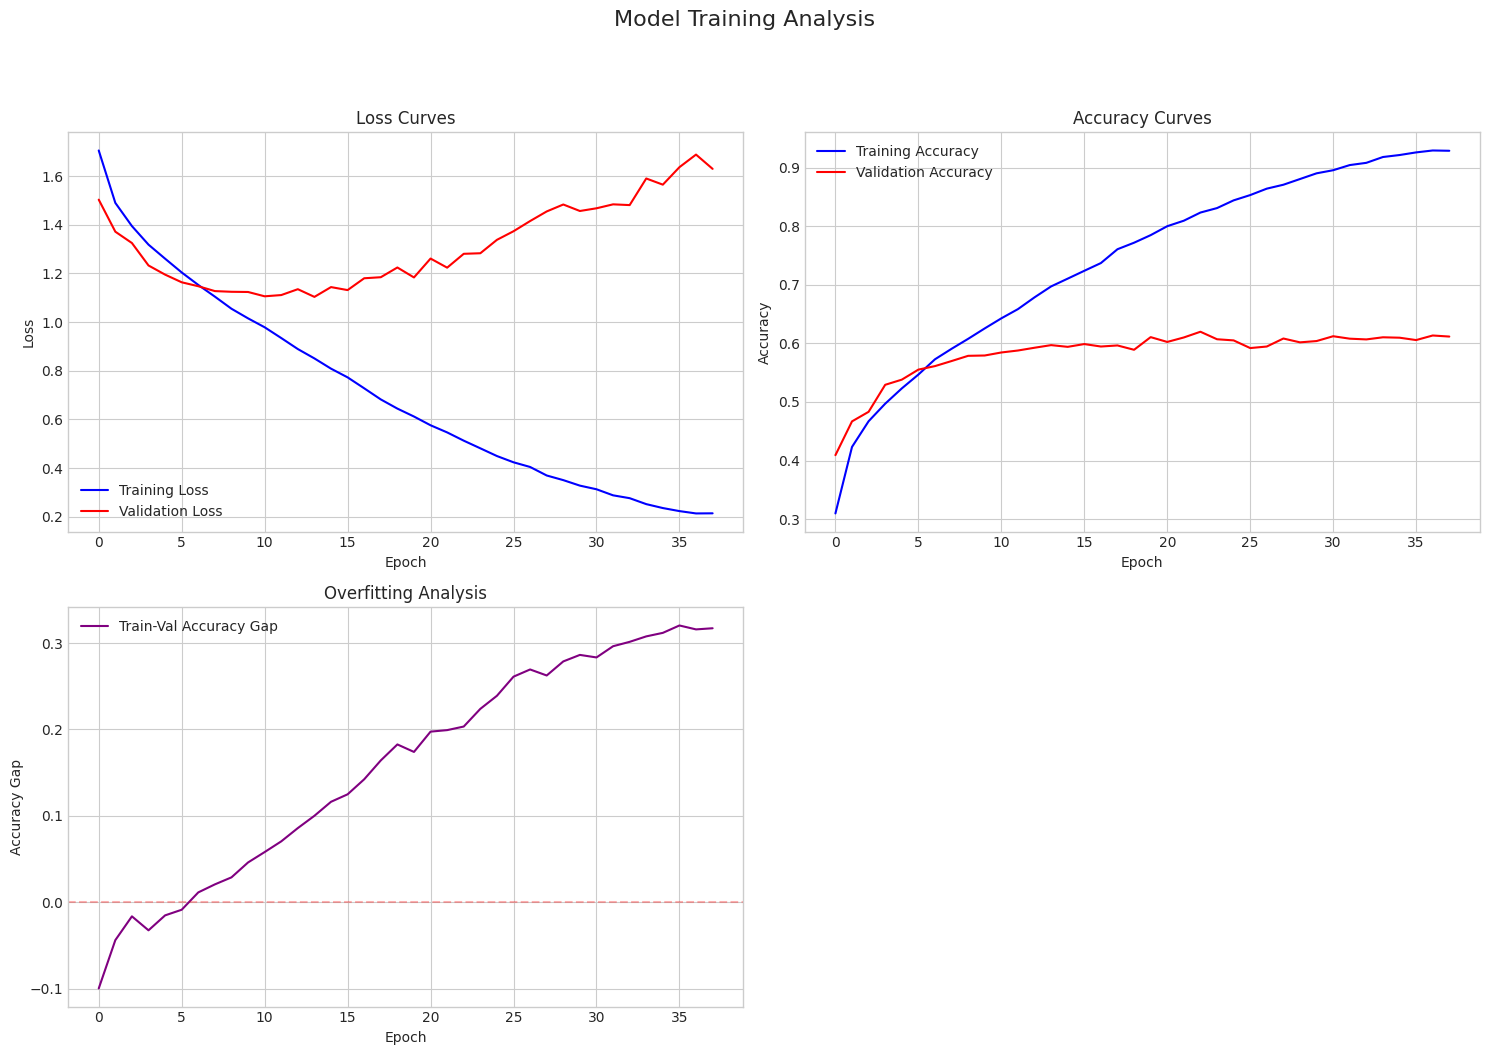

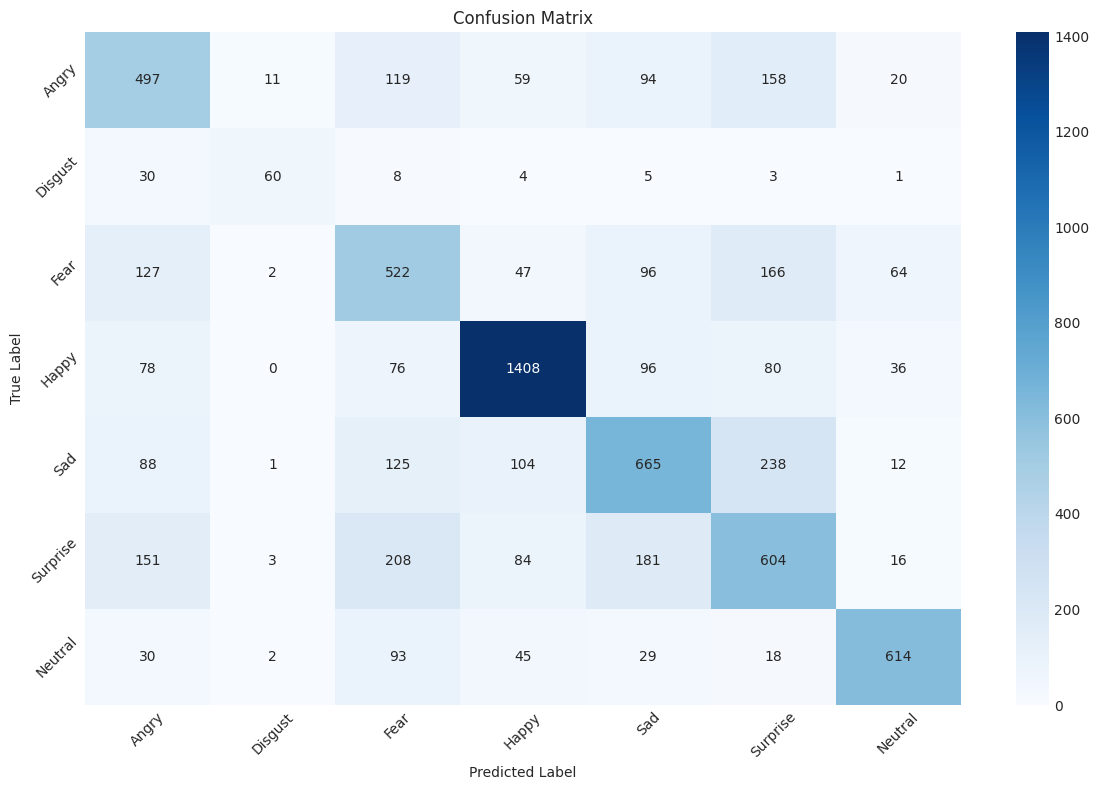


Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.52      0.51       958
     Disgust       0.76      0.54      0.63       111
        Fear       0.45      0.51      0.48      1024
       Happy       0.80      0.79      0.80      1774
         Sad       0.57      0.54      0.55      1233
    Surprise       0.48      0.48      0.48      1247
     Neutral       0.80      0.74      0.77       831

    accuracy                           0.61      7178
   macro avg       0.62      0.59      0.60      7178
weighted avg       0.62      0.61      0.61      7178



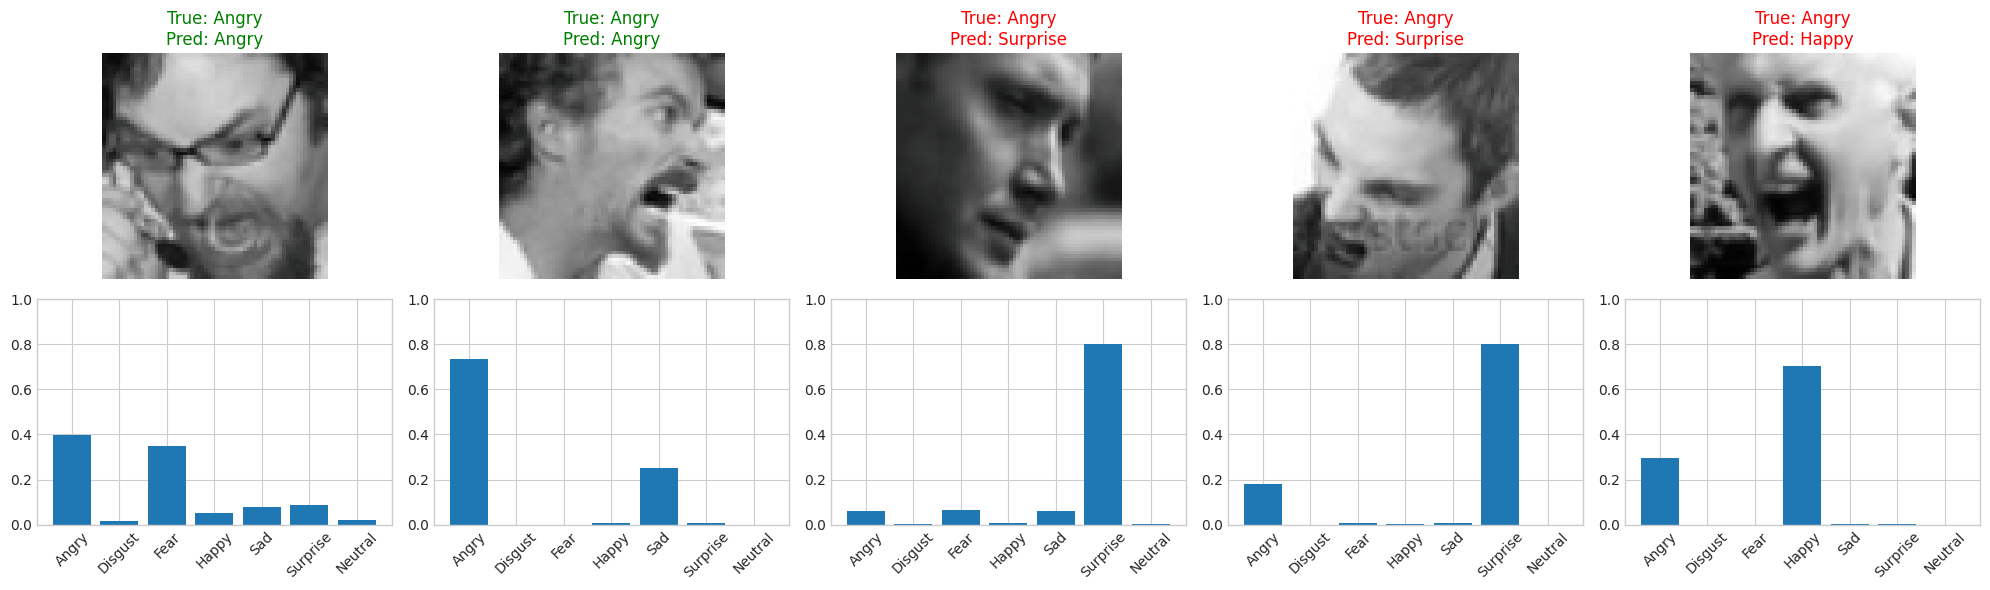

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)